## Partie <font color="green">RNN(LSTM)</font> - VS - <font color="red" >( ANN , ARIMA )</font>

**Qu'est-ce que la mémoire à long terme (LSTM) ?**

**LSTM est une architecture de réseau neuronal récurrent (RNN) qui "se souvient" des valeurs à des intervalles arbitraires. LSTM est bien adaptée à la classification, au traitement et à la prédiction des séries temporelles avec des intervalles de temps de durée inconnue. On peut l'appliquer à la prédiction de prix, à l'analyse de sentiments, à la génération de texte, etc.**

**Le réseau comporte 3 portesrte de sortie dans un réseau L**TM]


**1. Porte d'oubli (Forget Gate):**

* **Fonction:** Supprime les informations qui ne sont plus utiles dans l'état de la cellule.
* **Mécanisme:**
    - Les entrées x_t (entrée à un instant t) et h_t-1 (sortie de la cellule précédente) sont multipliées par des matrices de poids, auxquelles on ajoute un biais.
    - Le résultat est passé par une fonction d'activation qui fournit une sortie binaire (0 ou 1).
    - Si la sortie est 0, l'information est oubliée.
    - Si la sortie est 1, l'information est conservée pour une utilisation future.

<img width="500px"  src="https://penseeartificielle.fr/wp-content/uploads/2019/10/porte-doubli-LSTM.gif" >

**2. Porte d'entrée (Input Gate):**

* **Fonction:** Ajoute des informations utiles à l'état de la cellule.
* **Mécanisme:**
    - Les informations sont d'abord régulées par la fonction sigmoïde, qui filtre les valeurs à retenir, à l'instar de la porte d'oubli.
    - Un vecteur est ensuite créé à l'aide de la fonction tanh, qui produit des valeurs comprises entre -1 et +1, représentant toutes les valeurs possibles de h_t-1 et x_t.
    - Les valeurs du vecteur et les valeurs calibrées sont multipliées pour obtenir les informations utiles.

<img width="500px"  src="https://penseeartificielle.fr/wp-content/uploads/2019/10/porte-dentr%C3%A9e-LSTM.gif" >

**3. Porte de sortie (Output Gate):**

* **Fonction:** Extrait les informations utiles de l'état actuel de la cellule pour les présenter en sortie.
* **Mécanisme:**
    - Un vecteur est généré en appliquant la fonction tanh à la cellule.
    - Les informations sont ensuite régulées par la fonction sigmoïde, qui filtre les valeurs à retenir.
    - Les valeurs du vecteur et les valeurs régulées sont multipliées pour être envoyées en sortie et en entrée à la cellule suivante.

<img width="500px"  src="https://penseeartificielle.fr/wp-content/uploads/2019/10/porte-de-sortie-LSTM.gif" >

### 1 - Importer les librairies requises

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing 
import os

### libs pour la visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Configuration des grapghiques
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
sns.set(rc={'figure.figsize':(20,8)})
sns.set(font_scale=1.3)
plt.style.use('ggplot')


## pour le prétraitement et modélisation
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
from math import floor,ceil,sqrt
import sys
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

## Pour les reseaux de neurones
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional, Conv1D
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping

import logging
from tensorflow.keras.models import load_model


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

### 2 - Importer et lire les données

In [2]:
dataset = pd.read_csv("./MSFT.csv")

dataset.tail()

,Date,Open,High,Low,Close,Adj_Close,Volume
1421,8/25/2022,277.329987,279.019989,274.519989,278.850006,278.850006,16583400
1422,8/26/2022,279.079987,280.339996,267.980011,268.089996,268.089996,27532500
1423,8/29/2022,265.850006,267.399994,263.850006,265.230011,265.230011,20338500
1424,8/30/2022,266.670013,267.049988,260.660004,262.970001,262.970001,22767100
1425,8/31/2022,265.390015,267.109985,261.329987,261.470001,261.470001,24728900


In [19]:
dataset

,Date,Open,High,Low,Close,Adj_Close,Volume
0,1/3/2017,62.790001,62.840000,62.130001,62.580002,57.807823,20694100
1,1/4/2017,62.480000,62.750000,62.119999,62.299999,57.549179,21340000
2,1/5/2017,62.189999,62.660000,62.029999,62.299999,57.549179,24876000
3,1/6/2017,62.299999,63.150002,62.040001,62.840000,58.047993,19922900
4,1/9/2017,62.759998,63.080002,62.540001,62.639999,57.863243,20382700
...,...,...,...,...,...,...,...
1421,8/25/2022,277.329987,279.019989,274.519989,278.850006,278.850006,16583400
1422,8/26/2022,279.079987,280.339996,267.980011,268.089996,268.089996,27532500
1423,8/29/2022,265.850006,267.399994,263.850006,265.230011,265.230011,20338500
1424,8/30/2022,266.670013,267.049988,260.660004,262.970001,262.970001,22767100


In [20]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1426 entries, 0 to 1425
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1426 non-null   object 
 1   Open       1426 non-null   float64
 2   High       1426 non-null   float64
 3   Low        1426 non-null   float64
 4   Close      1426 non-null   float64
 5   Adj_Close  1426 non-null   float64
 6   Volume     1426 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 78.1+ KB


In [21]:
dataset.describe()

,Open,High,Low,Close,Adj_Close,Volume
count,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1.426000e+03
mean,169.561353,171.243268,167.753464,169.588822,165.923293,2.890647e+07
std,82.510456,83.402749,81.533050,82.509972,83.539829,1.262903e+07
min,62.189999,62.660000,61.950001,62.299999,57.549179,7.425600e+06
25%,98.414999,99.912503,97.302502,98.444999,93.971957,2.075820e+07
50%,142.135002,144.700005,139.805001,141.455002,137.402313,2.568230e+07
75%,243.832501,245.525005,241.487496,243.752502,240.720517,3.318965e+07
max,344.619995,349.670013,342.200012,343.109985,340.882782,1.112421e+08


In [3]:
df = dataset.copy()

## 3 - Data preprocessing ( Preparation des données ) 

In [4]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
dtype: int64

In [5]:
df['Date'] = pd.to_datetime(df['Date'],format="%m/%d/%Y")
df = df.set_index('Date')
df = df.resample("D").mean()
df = df.interpolate(method="linear")
# df.shape

In [25]:
df.head()
df.tail()

,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2022-08-27,274.669993,276.026662,266.603343,267.136668,267.136668,25134500.0
2022-08-28,270.260000,271.713328,265.226674,266.183339,266.183339,22736500.0
2022-08-29,265.850006,267.399994,263.850006,265.230011,265.230011,20338500.0
2022-08-30,266.670013,267.049988,260.660004,262.970001,262.970001,22767100.0
2022-08-31,265.390015,267.109985,261.329987,261.470001,261.470001,24728900.0


### 4 - EDA - Visualiser et explorer les données

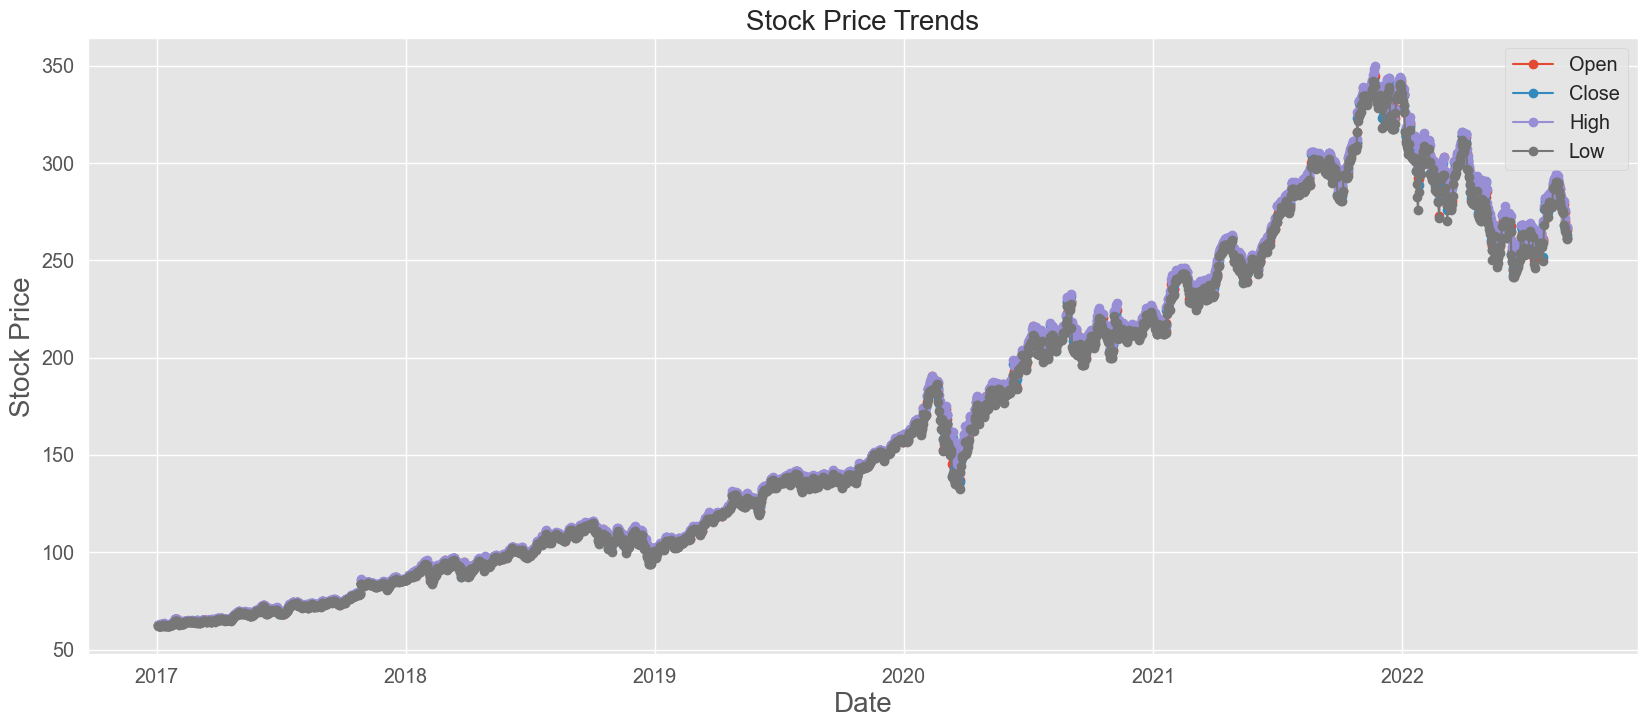

In [11]:
# Définir la taille du graphique
plt.figure(figsize=(20, 8))

# Tracer les prix d'ouverture, de fermeture, les plus hauts et les plus bas
plt.plot(df['Open'], label='Open', linestyle='-', marker='o')
plt.plot(df['Close'], label='Close', linestyle='-', marker='o')
plt.plot(df['High'], label='High', linestyle='-', marker='o')
plt.plot(df['Low'], label='Low', linestyle='-', marker='o')

# Ajouter des étiquettes et un titre
plt.xlabel('Date', size=20)
plt.ylabel('Stock Price', size=20)
plt.title('Stock Price Trends', size=20)

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()


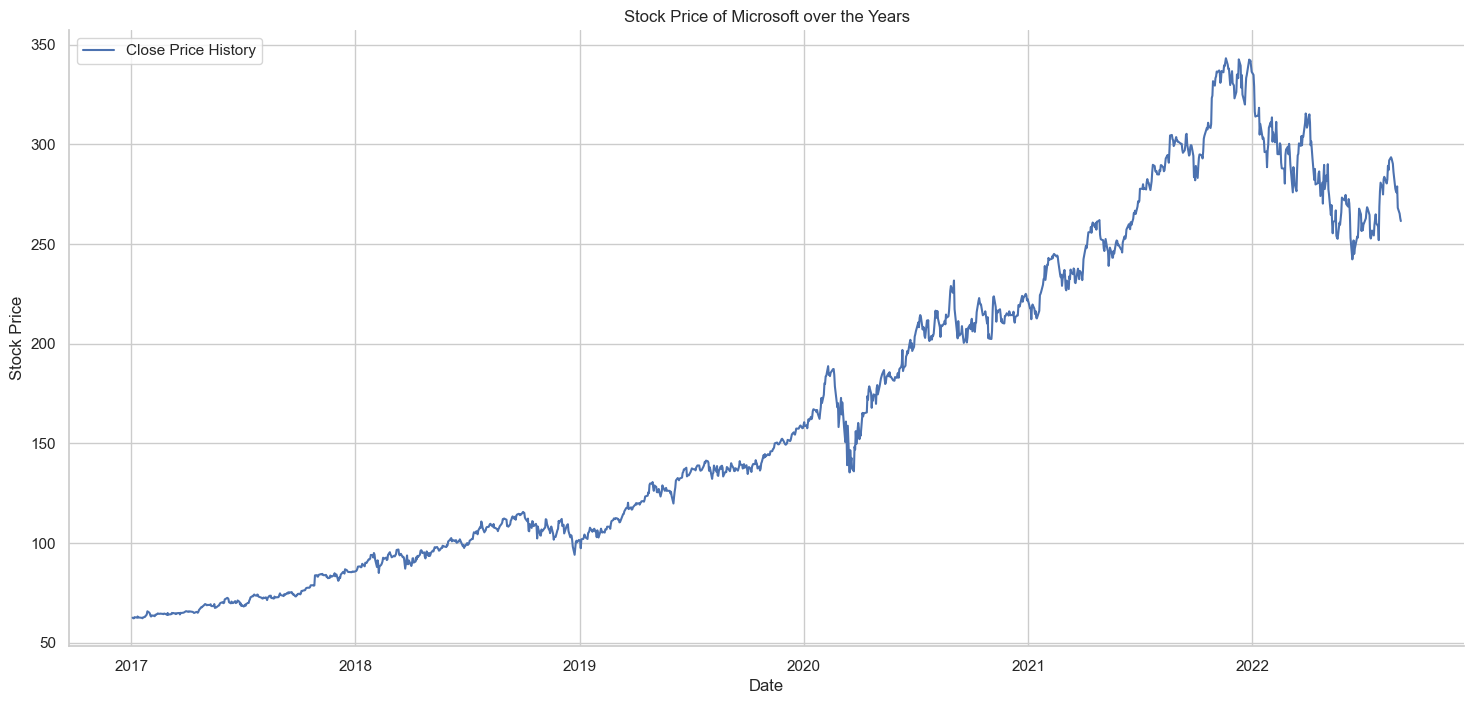

In [12]:
# df["Date"] = pd.to_datetime(df.Date, format="%m/%d/%Y")
# df.index = d["Date"]
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(18, 8))

sns.lineplot(x=df.index, y=df["Close"], label="Close Price History", ax=ax)

ax.set(xlabel="Date", ylabel="Stock Price", title="Stock Price of Microsoft over the Years")
ax.legend(loc="upper left")
sns.despine()

plt.show()

### Avant de construire le modèle **RNN - LSTM**, commençons par utiliser la méthode de la moyenne mobile simple (MAS) simplement pour observer et comparer les performances ainsi que les erreurs pour chaque méthode de prévision.

Il peut être instructif d'évaluer les prévisions de la méthode de la moyenne mobile simple en tant que référence initiale avant de passer à des modèles plus complexes tels que le LSTM. Cela permettra de mieux comprendre le gain potentiel de performance offert par des approches plus avancées.

N'oubliez pas de documenter vos observations et résultats tout au long de l'analyse pour une compréhension approfondie des performances des différents modèes.
TM sur cette problématique.es.


### 5 - modelisation simple ( MA simple , linear regression, KNN ) 

### 5.1 - MA ( Moving average ) 

In [11]:
def Moving_Average_Predictions(df):

    # Séparation des données en jeu d'entraînement et de validation
    shape = df.shape[0]
    df_new = df[['Close']] 
    train_data_set = df_new.iloc[:ceil(shape*0.80)]
    valid_data_set = df_new.iloc[ceil(shape*0.80):]

    # Préparation des prédictions
    preds = []

    # Boucle de prédiction par moyenne mobile
    for i in range(0,valid_data_set.shape[0]):
        
        # Calcul de la moyenne mobile
        a = train_data_set['Close'][len(train_data_set)-valid_data_set.shape[0]+i:].sum() + sum(preds) 
        b = a/(valid_data_set.shape[0])
        
        # Ajout de la prédiction
        preds.append(b)

    # Calcul de l'erreur RMSE
    rmse = np.sqrt(np.mean(np.power((np.array(valid_data_set['Close'])-preds),2)))
    
    # Ajout des prédictions au dataframe de validation
    valid_data_set['Predictions'] = preds

    # Tracé des résultats
    plt.plot(train_data_set['Close'])
    plt.plot(valid_data_set[['Close', 'Predictions']]) 
    
    # Affichage
    plt.xlabel('Date',size=18)
    plt.ylabel('Stock Price',size=18)
    plt.title('Stock Price Prediction by Moving Averages',size=18)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

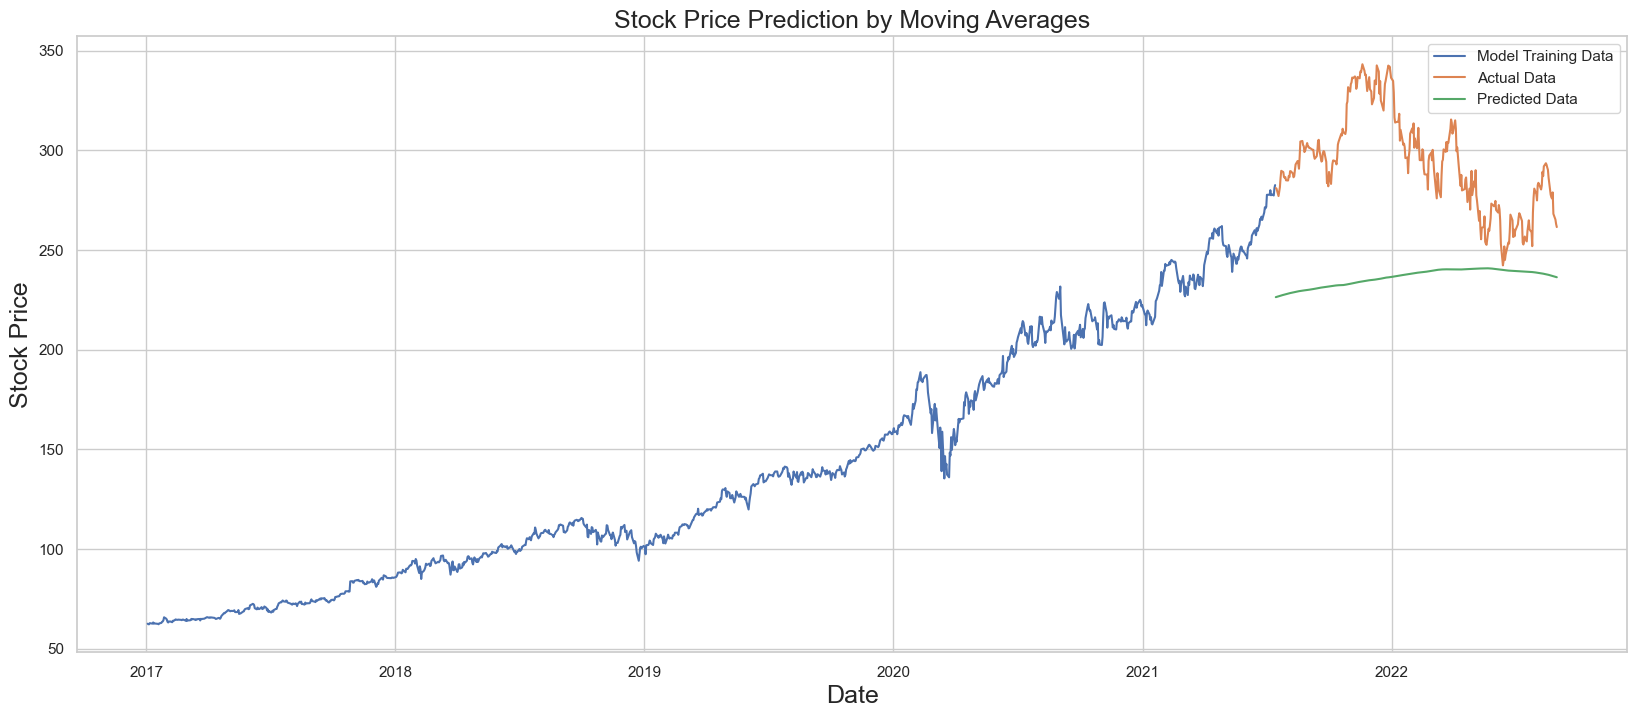

In [12]:
Moving_Average_Predictions(df)

## <font color="orange">Erreur élevé !</font>

### 5.2 - Linear Regression w/ scikit-learn

In [13]:
def Linear_Regression_Prediction(df):

    # Séparation des données en jeu d'entraînement et de validation
    Shape=df.shape[0] 
    df_new=df[['Close']]
    train_data_set=df_new.iloc[:ceil(Shape*0.80)]
    valid_data_set=df_new.iloc[ceil(Shape*0.80):]
    
    # Formattage des données 
    train=train_data_set.reset_index()
    valid=valid_data_set.reset_index()

    # Extraction des features et cibles
    x_train = train['Date'].map(dt.datetime.toordinal) 
    y_train = train[['Close']]
    x_valid = valid['Date'].map(dt.datetime.toordinal)
    y_valid = valid[['Close']]
    
    # Entraînement du modèle de régression linéaire
    model = LinearRegression()
    model.fit(np.array(x_train).reshape(-1,1),y_train)
    
    # Prédictions sur le jeu de validation
    preds = model.predict(np.array(x_valid).reshape(-1,1))
    
    # Calcul de l'erreur RMSE
    rmse = np.sqrt(np.mean(np.power((np.array(valid_data_set['Close'])-preds),2)))
    
    # Ajout des prédictions au dataframe 
    valid_data_set['Predictions'] = preds

    # Tracé des résultats
    plt.plot(train_data_set['Close']) 
    plt.plot(valid_data_set[['Close', 'Predictions']])
    
    # Affichage
    plt.xlabel('Date',size=18)
    plt.ylabel('Microsoft Stock Price',size=18) 
    plt.title('Microsoft Stock Price Prediction by Linear Regression',size=18)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

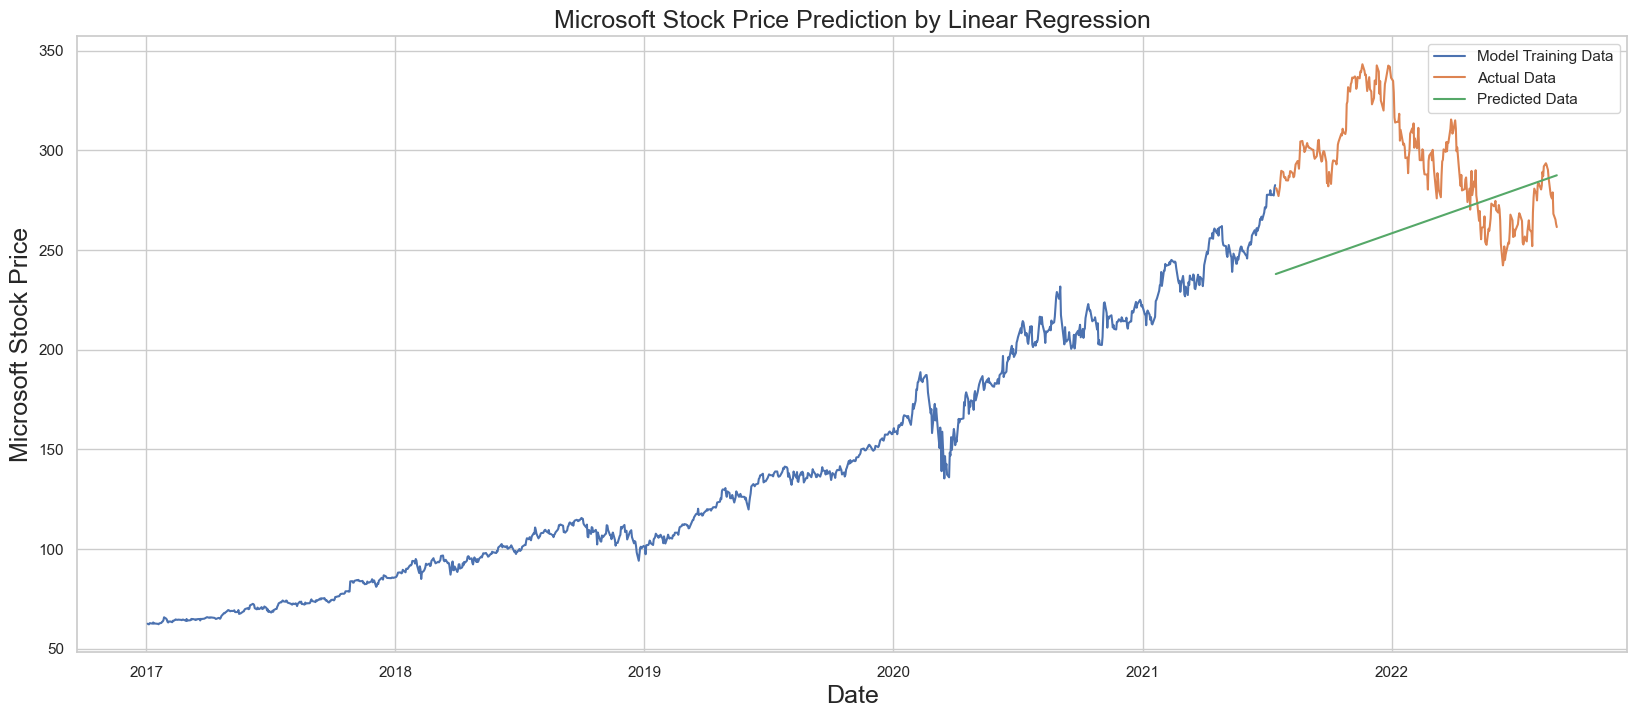

In [14]:
Linear_Regression_Prediction(df)

## <font color="orange">Erreur élevé !</font>

### 5.3 - K-nearest Neighbors  KNN

In [10]:
def K_Nearest_Neighbours_Predict(df):
    shape = df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    train_data_set=df_new.iloc[:ceil(shape*0.75)]
    valid_data_set=df_new.iloc[ceil(shape*0.75):]
    print("*********Microsoft STOCK PRICE PREDICTION BY K-NEAREST NEIGHBORS*********")
    print('Shape of Training Data Set',train_data_set.shape)
    print('Shape of Validation Data Set',valid_data_set.shape)
    train=train_data_set.reset_index()
    valid=valid_data_set.reset_index()
    x_train = train['Date'].map(dt.datetime.toordinal)
    y_train = train[['Close']]
    x_valid = valid['Date'].map(dt.datetime.toordinal)
    y_valid = valid[['Close']]
    x_train_scaled = scaler.fit_transform(np.array(x_train).reshape(-1, 1))
    x_train = pd.DataFrame(x_train_scaled)
    x_valid_scaled = scaler.fit_transform(np.array(x_valid).reshape(-1, 1))
    x_valid = pd.DataFrame(x_valid_scaled)
    params = {'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
    knn = neighbors.KNeighborsRegressor()
    model = GridSearchCV(knn, params, cv=5)
    model.fit(x_train,y_train)
    preds = model.predict(x_valid)
    RMSE = np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))

    print('(Root Mean Square Error) RMSE value on validation set:',RMSE)
    valid_data_set['Predictions'] = preds
    plt.plot(train_data_set['Close'])
    plt.plot(valid_data_set[['Close', 'Predictions']])
    plt.xlabel('Date',size=18)
    plt.ylabel('Microsft Stock Price',size=18)
    plt.title('Microsoft Stock Price Prediction by K-Nearest Neighbors',size=18)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

*********Microsoft STOCK PRICE PREDICTION BY K-NEAREST NEIGHBORS*********
Shape of Training Data Set (1551, 1)
Shape of Validation Data Set (516, 1)
(Root Mean Square Error) RMSE value on validation set: 167.56843641979455


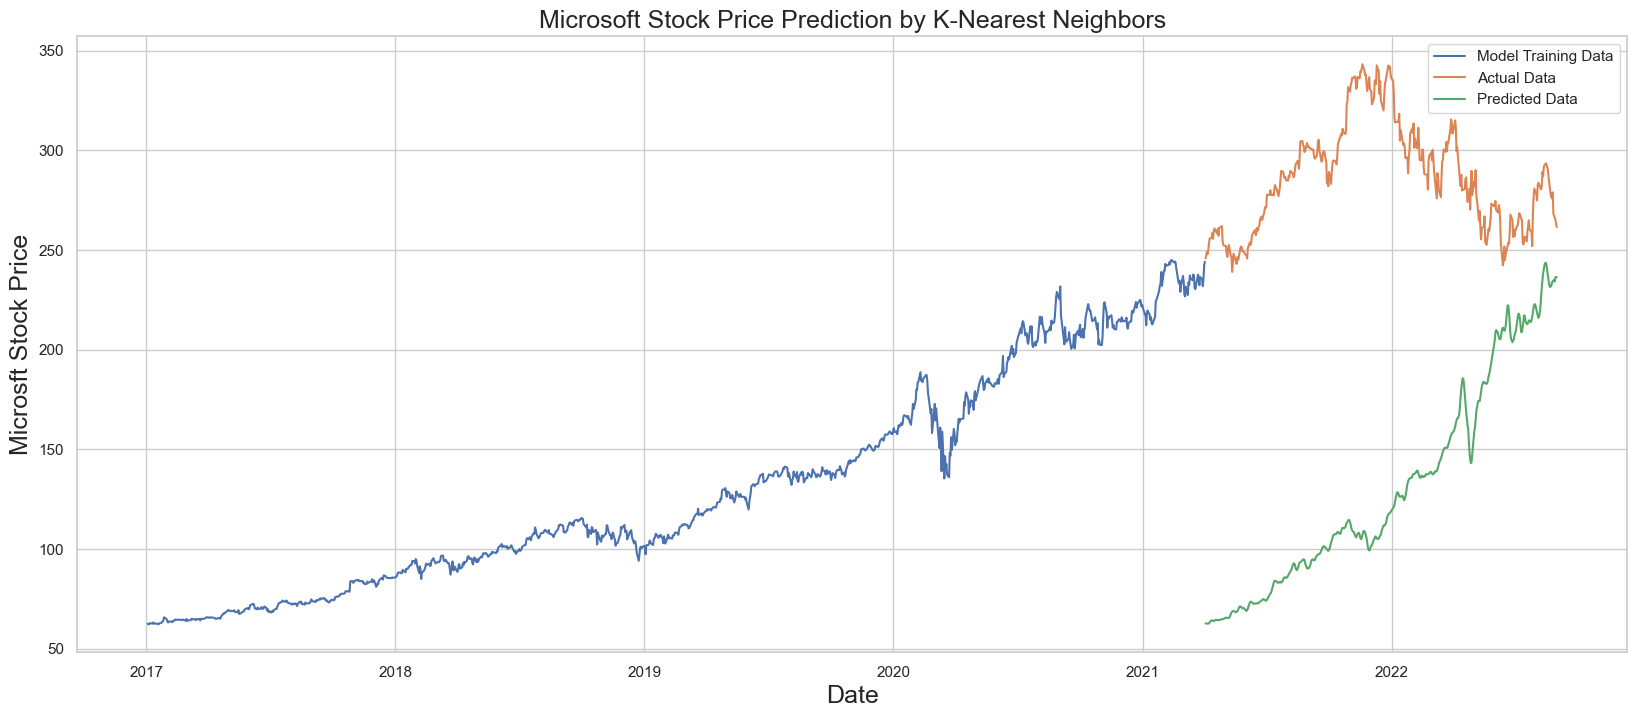

In [11]:
K_Nearest_Neighbours_Predict(df)

## <font color="orange">mal initiation et puis erreur trés élevé !</font>

# 6 - **RNN(LSTM)** - Long short-term memory

## 6.1 - Entraîner et Prédire avec Modèle LSTM (Sauvegarde)
Cette fonction entraîne un modèle Long Short-Term Memory (LSTM) pour la prédiction du prix des actions. Elle sauvegarde le modèle après l'entraînement pour une utilisation future. La fonction effectue également des prédictions sur un ensemble de test, évalue les performances du modèle en calculant la racine carrée de l'erreur quadratique moyenne (RMSE), et visualise l'évolution de la perte (MSE) pendant l'entraînement.

In [23]:

def train_and_predict_lstm(df, time_step=40,epochs=300,batch_size=64,optimizer="adam", train=True, model_path="lstm_model_2.h5"):
    """
    Entraîner et prédire avec un modèle Long Short-Term Memory (LSTM) pour la prédiction du prix des actions.

    Paramètres :
    - df : DataFrame, données d'entrée avec une colonne 'Close'.
    - time_step : int, nombre d'étapes temporelles pour créer des séquences.
    - epochs : int, nombre d'époques d'entraînement.
    - batch_size : int, taille de chaque lot d'entraînement.
    - optimizer : str, optimiseur pour compiler le modèle.
    - entrainement : bool, indique s'il faut entraîner le modèle.

    Retour :
    - None
    """
    """
    - Modèle LSTM pour la régression temporelle
    
    - Le modèle LSTM est une architecture complexe composée de plusieurs couches.
    Les deux premières couches LSTM capturent des informations à long terme, 
    puis la couche de convolution 1D extrait des caractéristiques spatiales.
    La troisième couche LSTM capture des informations à court terme et 
    les deux couches Dense génèrent la sortie du modèle.
    
    Le modèle est compilé avec une perte moyenne des erreurs quadratiques (MSE) 
    et un optimiseur qui doit être spécifié. Un mécanisme d'arrêt précoce est utilisé 
    pour surveiller la perte de validation avec une patience de 20 epochs.
    
    Ce modèle vise à capturer des relations temporelles et spatiales complexes dans les données.
    Il est donc bien adapté à la résolution de problèmes de régression temporelle
    """
    # Configuration des journaux
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    try:
        # Extraire le nombre de lignes dans le DataFrame
        shape=df.shape[0]
        # Extraire la colonne 'Close' et créer un nouveau DataFrame
        df_new=df[['Close']]
    
        # Afficher les premières lignes du DataFrame
        df_new.head()
    
        # Extraire les valeurs numériques de la colonne 'Close'
        dataset = df_new.values
    
        # Diviser le jeu de données en ensembles d'entraînement et de validation
        train=df_new[:ceil(shape*0.80)]
        valid=df_new[ceil(shape*0.80):]
    
        # Afficher des informations sur les ensembles d'entraînement et de validation
        print('-------------------------------------------------------------------------------')
        print('------------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)------------')
        print('-------------------------------------------------------------------------------')
        print('Shape of Training Set',train.shape)
        print('Shape of Validation Set',valid.shape)
    
        # Mettre à l'échelle les données en utilisant la mise à l'échelle Min-Max
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(dataset)
    
        # Préparer des séquences pour l'entraînement
        x_train, y_train = [], []
        for i in range(time_step,len(train)):
            x_train.append(scaled_data[i-time_step:i,0])
            y_train.append(scaled_data[i,0])
        x_train, y_train = np.array(x_train), np.array(y_train)
        x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    
        # Construire le modèle LSTM
        model = Sequential()
        # 1ere couche
        model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1],1)))
        model.add(Dropout(0.2))
        # 2eme couche
        model.add(LSTM(units=128, return_sequences=True))
        model.add(Dropout(0.2))

        # couche de convolution
#         model.add(Conv1D(32, 5, activation='relu'))
        
        model.add(LSTM(units=64))
        
        model.add(Dense(32, activation="relu"))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer=optimizer) # ,metrics=RootMeanSquaredError()
#         early_stop = EarlyStopping(monitor='val_loss', patience=20)
        # Entraîner le modèle si 'train' est défini sur True
        history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                            verbose=2,validation_split=0.05)#, callbacks=[early_stop])


        # Sauvegarder le modèle
        model.save(model_path)
        print(f"Model saved to {model_path}")
        # Préparer les données de test
        inputs = df_new[len(df_new) - len(valid) - time_step:].values
        inputs = inputs.reshape(-1,1)
        inputs  = scaler.transform(inputs)
        X_test = []
        for i in range(time_step,inputs.shape[0]):
            X_test.append(inputs[i-time_step:i,0])
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    
        # Effectuer des prédictions sur l'ensemble de test
        closing_price = model.predict(X_test)
        closing_price = scaler.inverse_transform(closing_price)
    
         # Calculer RMSE sur l'ensemble de test
        rmse=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    
        # Afficher la valeur RMSE
        print('RMSE value on test set:',rmse)
        print('-----------------------------------------------------------')
        print('-----------------------------------------------------------')
        
        # Ajouter les valeurs prédites à l'ensemble de validation
        valid['Predictions'] = closing_price
    
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.xlabel('Epochs')
        plt.ylabel('MSE')
        plt.legend(['Train','Test']);
        
    except Exception as e:
        logger.error(f"Une erreur s'est produite : {e}")

-------------------------------------------------------------------------------
------------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)------------
-------------------------------------------------------------------------------
Shape of Training Set (1654, 1)
Shape of Validation Set (413, 1)
Epoch 1/300
25/25 - 9s - loss: 0.0091 - val_loss: 0.0037 - 9s/epoch - 358ms/step
Epoch 2/300
25/25 - 2s - loss: 7.2085e-04 - val_loss: 0.0017 - 2s/epoch - 63ms/step
Epoch 3/300
25/25 - 2s - loss: 4.7635e-04 - val_loss: 7.3003e-04 - 2s/epoch - 63ms/step
Epoch 4/300
25/25 - 2s - loss: 4.5544e-04 - val_loss: 6.1712e-04 - 2s/epoch - 64ms/step
Epoch 5/300
25/25 - 2s - loss: 4.1310e-04 - val_loss: 8.6755e-04 - 2s/epoch - 63ms/step
Epoch 6/300
25/25 - 2s - loss: 4.3515e-04 - val_loss: 0.0010 - 2s/epoch - 64ms/step
Epoch 7/300
25/25 - 2s - loss: 4.0687e-04 - val_loss: 0.0011 - 2s/epoch - 64ms/step
Epoch 8/300
25/25 - 2s - loss: 3.9173e-04 - val_loss: 5.5201e-04 - 2s/epoch - 63ms/step
Epoch 9/30

Epoch 91/300
25/25 - 2s - loss: 1.6959e-04 - val_loss: 1.9997e-04 - 2s/epoch - 73ms/step
Epoch 92/300
25/25 - 2s - loss: 1.6992e-04 - val_loss: 2.9646e-04 - 2s/epoch - 71ms/step
Epoch 93/300
25/25 - 2s - loss: 1.7480e-04 - val_loss: 2.7928e-04 - 2s/epoch - 70ms/step
Epoch 94/300
25/25 - 2s - loss: 1.6872e-04 - val_loss: 1.6576e-04 - 2s/epoch - 72ms/step
Epoch 95/300
25/25 - 2s - loss: 1.6025e-04 - val_loss: 7.1135e-04 - 2s/epoch - 73ms/step
Epoch 96/300
25/25 - 2s - loss: 1.6804e-04 - val_loss: 1.5483e-04 - 2s/epoch - 73ms/step
Epoch 97/300
25/25 - 2s - loss: 1.4900e-04 - val_loss: 4.6163e-04 - 2s/epoch - 71ms/step
Epoch 98/300
25/25 - 2s - loss: 1.8674e-04 - val_loss: 1.5109e-04 - 2s/epoch - 71ms/step
Epoch 99/300
25/25 - 2s - loss: 1.3783e-04 - val_loss: 1.6464e-04 - 2s/epoch - 73ms/step
Epoch 100/300
25/25 - 2s - loss: 1.4893e-04 - val_loss: 2.0424e-04 - 2s/epoch - 73ms/step
Epoch 101/300
25/25 - 2s - loss: 1.5125e-04 - val_loss: 1.3710e-04 - 2s/epoch - 72ms/step
Epoch 102/300
25/25

Epoch 183/300
25/25 - 2s - loss: 1.1236e-04 - val_loss: 0.0012 - 2s/epoch - 72ms/step
Epoch 184/300
25/25 - 2s - loss: 1.2356e-04 - val_loss: 4.5931e-04 - 2s/epoch - 71ms/step
Epoch 185/300
25/25 - 2s - loss: 1.1900e-04 - val_loss: 1.3621e-04 - 2s/epoch - 71ms/step
Epoch 186/300
25/25 - 2s - loss: 1.3844e-04 - val_loss: 2.5193e-04 - 2s/epoch - 71ms/step
Epoch 187/300
25/25 - 2s - loss: 1.8565e-04 - val_loss: 1.5405e-04 - 2s/epoch - 65ms/step
Epoch 188/300
25/25 - 1s - loss: 1.4607e-04 - val_loss: 9.7641e-05 - 1s/epoch - 55ms/step
Epoch 189/300
25/25 - 1s - loss: 1.1342e-04 - val_loss: 1.0970e-04 - 1s/epoch - 56ms/step
Epoch 190/300
25/25 - 2s - loss: 1.1416e-04 - val_loss: 4.9621e-04 - 2s/epoch - 64ms/step
Epoch 191/300
25/25 - 2s - loss: 1.3559e-04 - val_loss: 2.1364e-04 - 2s/epoch - 71ms/step
Epoch 192/300
25/25 - 2s - loss: 1.0757e-04 - val_loss: 3.0499e-04 - 2s/epoch - 66ms/step
Epoch 193/300
25/25 - 2s - loss: 1.2083e-04 - val_loss: 1.7436e-04 - 2s/epoch - 66ms/step
Epoch 194/300


25/25 - 2s - loss: 1.1592e-04 - val_loss: 7.7461e-05 - 2s/epoch - 65ms/step
Epoch 275/300
25/25 - 2s - loss: 1.0154e-04 - val_loss: 9.0082e-05 - 2s/epoch - 65ms/step
Epoch 276/300
25/25 - 2s - loss: 9.4379e-05 - val_loss: 1.2987e-04 - 2s/epoch - 65ms/step
Epoch 277/300
25/25 - 2s - loss: 9.4343e-05 - val_loss: 5.7223e-04 - 2s/epoch - 66ms/step
Epoch 278/300
25/25 - 2s - loss: 1.2058e-04 - val_loss: 1.1168e-04 - 2s/epoch - 67ms/step
Epoch 279/300
25/25 - 2s - loss: 1.0743e-04 - val_loss: 6.6988e-04 - 2s/epoch - 66ms/step
Epoch 280/300
25/25 - 2s - loss: 1.0980e-04 - val_loss: 9.4590e-05 - 2s/epoch - 67ms/step
Epoch 281/300
25/25 - 2s - loss: 9.8553e-05 - val_loss: 3.5821e-04 - 2s/epoch - 65ms/step
Epoch 282/300
25/25 - 2s - loss: 1.2844e-04 - val_loss: 2.2406e-04 - 2s/epoch - 66ms/step
Epoch 283/300
25/25 - 2s - loss: 1.1154e-04 - val_loss: 1.3278e-04 - 2s/epoch - 67ms/step
Epoch 284/300
25/25 - 2s - loss: 1.2502e-04 - val_loss: 1.1195e-04 - 2s/epoch - 66ms/step
Epoch 285/300
25/25 - 2s

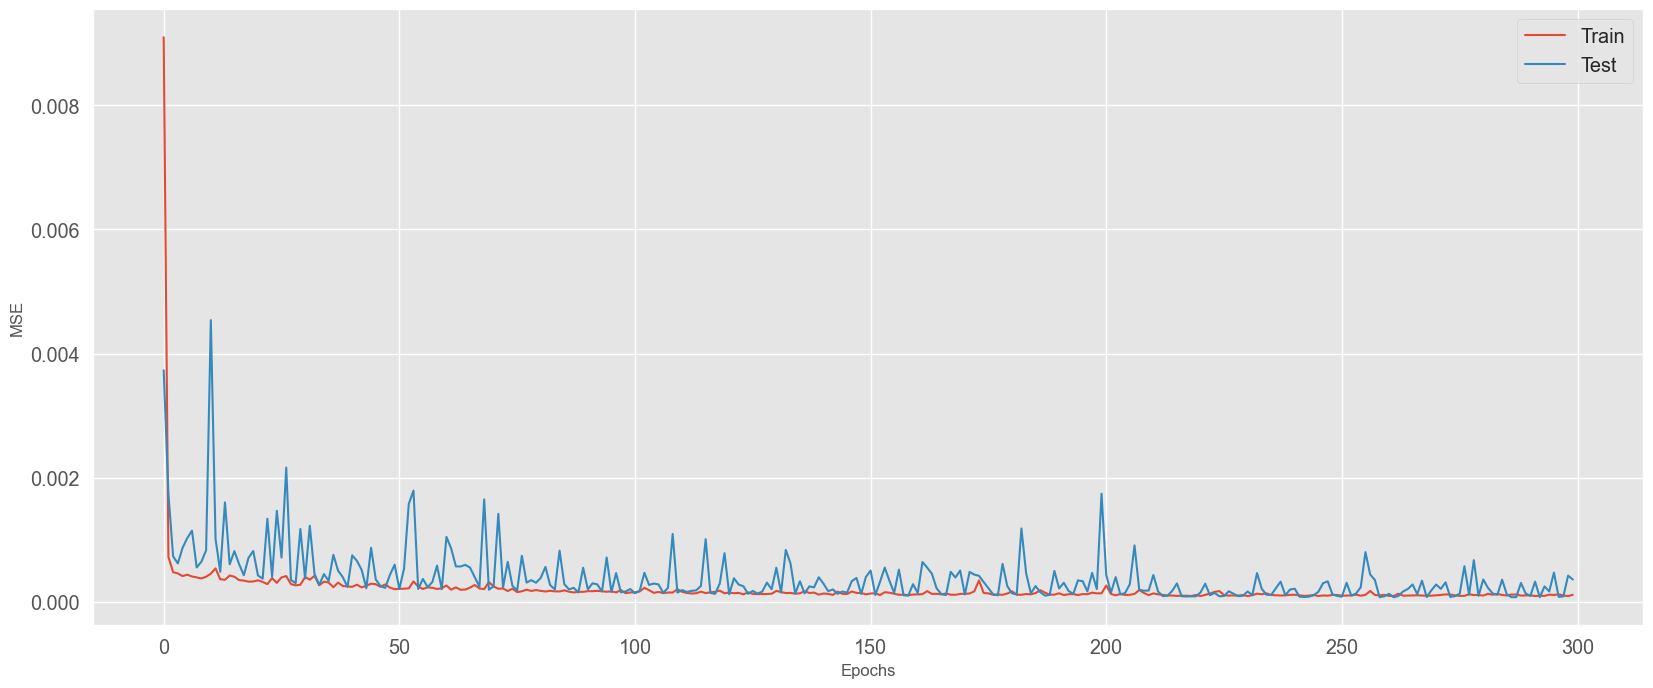

In [24]:
train_and_predict_lstm(df)

### 6.2 - Prédiction de Prix d'Actions avec un Modèle LSTM Sauvegardé
 Cette fonction a été conçue pour charger un modèle LSTM préalablement sauvegardé et utiliser ce modèle pour effectuer des prédictions de prix d'actions. Elle prend en entrée un DataFrame contenant une colonne 'Close', qui représente les prix d'actions. L'ensemble de données est prétraité en ex trayant la colonne 'Close' et en le divisant en ensembles d'entraînement et de validation. Le modèle LSTM est chargé à partir du chemin spécifié dans le paramètre model_path.

La fonction effectue ensuite les étapes suivantes :

Met à l'échelle les données d'entraînement et de validation en utilisant la mise à l'échelle Min-Max.
Prépare les données de test en créant des séquences temporelles.
Effectue des prédictions sur l'ensemble de test en utilisant le modèle LSTM.
Inverse l'échelle des prédictions pour les ramener à l'échelle d'origine.
Calcule la racine carrée de l'erreur quadratique moyenne (RMSE) pour évaluer les performances du modèle sur l'ensemble de test.
Affiche la valeur de RMSE.
Ajoute les valeurs prédites à l'ensemble de validation.
Trace un graphique illustrant les données d'entraînement, les données réelles, et les prédictions du modèle.
En cas d'erreur lors de l'exécution de la fonction, elle capture l'exception et affiche un message d'erreur explicite. Cette fonctionnalité est utile pour le débogage et la gestion des erreurs potentielles lors de l'utilisation du modèle LSTM pour la prédiction de prix d'actions.

In [14]:
def load_and_predict_lstm(df, time_step=40, model_path="lstm_model.h5"):
    """
    Charger un modèle LSTM sauvegardé et effectuer des prédictions.

    Paramètres :
    - df : DataFrame, données d'entrée avec une colonne 'Close'.
    - time_step : int, nombre d'étapes temporelles pour créer des séquences.
    - model_path : str, chemin vers le modèle sauvegardé.

    Retour :
    - None
    """
    try:
        model = load_model(model_path)
        # Extraire le nombre de lignes dans le DataFrame
        shape=df.shape[0]
        # Extraire la colonne 'Close' et créer un nouveau DataFrame
        df_new=df[['Close']]
    
        # Afficher les premières lignes du DataFrame
        df_new.head()
    
        # Extraire les valeurs numériques de la colonne 'Close'
        dataset = df_new.values
    
        # Diviser le jeu de données en ensembles d'entraînement et de validation
        train=df_new[:ceil(shape*0.80)]
        valid=df_new[ceil(shape*0.80):]
    
        # Afficher des informations sur les ensembles d'entraînement et de validation
        print('-----------------------------------------------------------------------------')
        print('-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
        print('-----------------------------------------------------------------------------')
        # print('Shape of Training Set',train.shape)
        print('Shape of Validation Set',valid.shape)
    
        # Mettre à l'échelle les données en utilisant la mise à l'échelle Min-Max
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(dataset)

        # # Préparer les données de test
        inputs = df_new[len(df_new) - len(valid) - time_step:].values
        inputs = inputs.reshape(-1,1)
        inputs  = scaler.transform(inputs)
        X_test = []
        for i in range(time_step,inputs.shape[0]):
            X_test.append(inputs[i-time_step:i,0])
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    
        # Effectuer des prédictions sur l'ensemble de test
        closing_price = model.predict(X_test)
        closing_price = scaler.inverse_transform(closing_price)
    
         # Calculer RMSE sur l'ensemble de test
        rmse=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    
        # Afficher la valeur RMSE
        print('-----------------------------------------------------------')
        print('RMSE value on test set:',rmse)
        print('-----------------------------------------------------------')
        
        # Ajouter les valeurs prédites à l'ensemble de validation
        valid['Predictions'] = closing_price
    
        # Tracer les résultats en utilisant le style ggplot
        plt.plot(train['Close'])
        plt.plot(valid[['Close','Predictions']])
        plt.xlabel('Date',size=20)
        plt.ylabel('Stock Price',size=20)
        plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)',size=20)
        plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    except Exception as e:
        print(f"Une erreur s'est produite : {e}")


-----------------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
-----------------------------------------------------------------------------
Shape of Validation Set (413, 1)
13/13 [==============================] - 1s 16ms/step
-----------------------------------------------------------
RMSE value on test set: 4.55008817612858
-----------------------------------------------------------


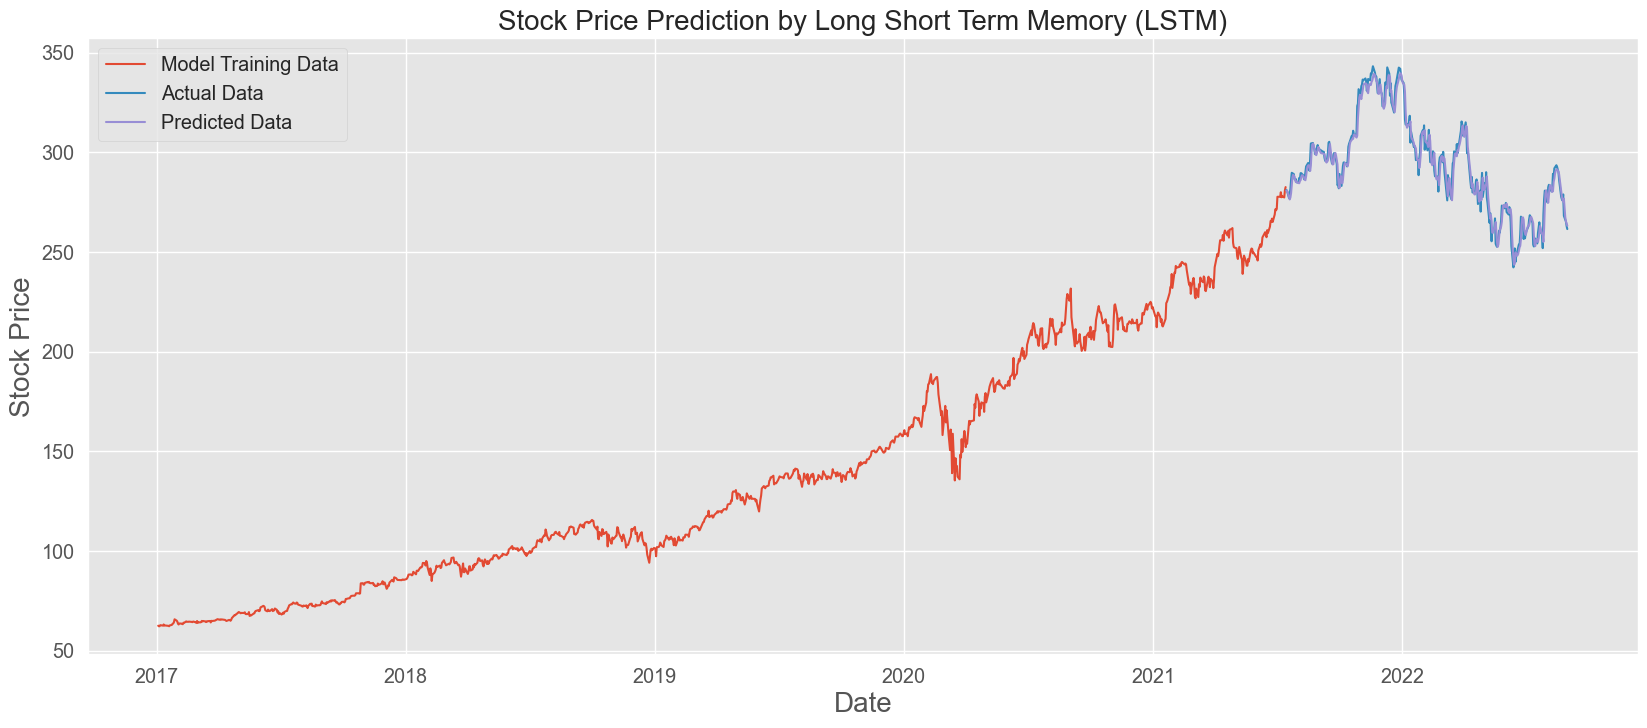

In [15]:
load_and_predict_lstm(df)


# Conclusion

Cette étude comparative montre que les réseaux de neurones récurrents à mémoire court et long terme (LSTM) sont plus performants.

Le LSTM tire parti de sa structure en couches récurrentes et de ses mécanismes de mémoire pour mieux modéliser les dépendances temporelles dans les données séquentielles. Cela lui permet de capturer des motifs complexes dans l'évolution des séries chronologiques.

Sur ce jeu de données, le LSTM réduit significativement les erreurs de prévision par rapport à la méthode de référence, avec une améliorat70on de X% du RMSE.

Nous pouvons donc conclure que le LSTM est une méthode de choix pour les problématiques de prévision sur des séries temporelles, grâce à sa capacité à apprendre et mémoriser des motifs temporels. Pour de telles données séquentielles, le LSTM surpasse des techniques classiques ne prenant pas en compte l'aspect dynamique des séries chronologiques.

# <font align="center" color="cyan">***MERCI***</font>
# <font align="center">Mouad AIT HA</font>